# A) API Zugriff im lokalen Netzwerk 

# Das sind die Inhalte:
## Sensor- Werte auslesen und speichern
1. request an das REST API senden und "return-object" analysieren
2. dictionary mit json.loads aus dem "return-object" erzeugen
3. dekodierte Sensor - Messwerte mit "print" ausgeben
4. Messwerte als .json file ablegen
5. Messwerte fortlaufend in einem .db file mitschreiben

### ->Arbeitsaufgabe 1 "Sensor - Werte speichern"

*Ersetze die "dummy-Werte" durch echte Sensordaten. 
Speichere die Werte für Luftfeuchtigkeit, Temperatur und Helligkeit:*
1. initialisiere ein neues .git repository und lege das "source" - file darin ab
2. speichere die Sensor - Werte in einem .json File "a_nachname_sensorwerte.json"
3. speichere die Sensor - Werte in einer sqlite Datenbank "a_nachname_sendorwerte.db"
4. füge das .json und .db file deinem git repository hinzu und führe ein commit durch. "-m "Arbeitsaufgabe Teil 1 Nachname"


Das Abfrageintervall ist eine Minute. Die Dauer der Aufzeichnung ist vor dem Start der Aufzeichnung
individuell mit dem Lehrer zu vereinbaren.



 

### A1) request an das REST API senden und "return-object" analysieren

In [22]:
import requests
import json
import time
#Die Authentifizierung wird im lokalen Netzwerk noch nicht benötigt, aber im nächsten Schritt
#from requests.auth import HTTPBasicAuth


In [23]:
my_hum_url = 'http://openhabian:8080/rest/items/ZWave_Node_003_Sensor_relative_humidity'
my_temp_url = 'http://openhabian:8080/rest/items/ZWave_Node_003_Sensor_temperature'

#my_hum_url='http://192.168.68.112:8080/rest/items/ZWaveNode019WohnzimmerZW100Multisensor6_Sensorrelativehumidity'
#my_temp_url='http://192.168.68.112:8080/rest/items/ZWaveNode019WohnzimmerZW100Multisensor6_Sensortemperature'
 

In [24]:
hum_value=requests.get(my_hum_url)
temp_value=requests.get(my_temp_url)
# Das JSON-Objekt wird über die Ausgabe der Requests-Objekt übergeben

In [25]:
print(hum_value.content)
print(temp_value.content)

b'{"link":"http://openhabian:8080/rest/items/ZWave_Node_003_Sensor_relative_humidity","state":"47","stateDescription":{"pattern":"%.1f","readOnly":true,"options":[]},"metadata":{"semantics":{"value":"Point","config":{"isPointOf":"ZWave_Node_003"}}},"editable":true,"type":"Number","name":"ZWave_Node_003_Sensor_relative_humidity","label":"Sensor (relative humidity)","category":"Humidity","tags":["Point"],"groupNames":["ZWave_Node_003"]}'
b'{"link":"http://openhabian:8080/rest/items/ZWave_Node_003_Sensor_temperature","state":"24.9 \xc2\xb0C","stateDescription":{"pattern":"%.1f %unit%","readOnly":true,"options":[]},"unitSymbol":"\xc2\xb0C","metadata":{"semantics":{"value":"Point","config":{"isPointOf":"ZWave_Node_003"}}},"editable":true,"type":"Number:Temperature","name":"ZWave_Node_003_Sensor_temperature","label":"Sensor (temperature)","category":"Temperature","tags":["Point"],"groupNames":["ZWave_Node_003"]}'


In [26]:
#TESTSTRING - AUSGEBEN
temp_dict=json.loads(temp_value.content)
act_temp = temp_dict['state']
act_temp = float(act_temp[:-2])
print(act_temp)
print(type(act_temp))

24.9
<class 'float'>


### A2) dictionary mit json.loads aus dem "return-object" erzeugen

In [27]:
import sqlite3
import time
#cnx = sqlite3.connect(':memory:') alternative in memory database
sqlite_db = 'a_sensor_values.db' # String for creating DB in specified directory
print(sqlite_db)

conn=sqlite3.connect(sqlite_db) # Creates sqlite Database - check in your file explorer
cur=conn.cursor()
#cur.execute('''DROP TABLE IF EXISTS sensor_values''')
#cur.execute('''CREATE TABLE sensor_values(timestamp NUMERIC,temperature NUMERIC, humidity NUMERIC);''') # Create table with specified name and columns/attributes
# 

for my_counter in range(15):
    time.sleep(60)
    my_timestamp = round(time.time())
    hum_value=requests.get(my_hum_url)
    temp_value=requests.get(my_temp_url)
    hum_dict=json.loads(hum_value.content)
    act_hum = hum_dict['state']
    temp_dict=json.loads(temp_value.content)
    act_temp = temp_dict['state']
    act_temp = float(act_temp[:-2]) 
     # The temperature value is stored without the "C" in the end.
     # The temperature value is in degrees centi-degrees.

    
# CREATE INSERT STATEMENT
    execution_string = f"INSERT INTO sensor_values VALUES ({my_timestamp}, {act_temp}, {act_hum})"
    print(execution_string)
    cur.execute(execution_string)
    conn.commit()

a_sensor_values.db
INSERT INTO sensor_values VALUES (1717580732, 24.8, 46)
INSERT INTO sensor_values VALUES (1717580793, 24.9, 46)
INSERT INTO sensor_values VALUES (1717580854, 24.8, 47)
INSERT INTO sensor_values VALUES (1717580916, 24.8, 47)
INSERT INTO sensor_values VALUES (1717580977, 24.8, 47)
INSERT INTO sensor_values VALUES (1717581039, 24.8, 47)
INSERT INTO sensor_values VALUES (1717581101, 24.8, 48)
INSERT INTO sensor_values VALUES (1717581163, 24.8, 48)
INSERT INTO sensor_values VALUES (1717581224, 24.9, 48)
INSERT INTO sensor_values VALUES (1717581285, 24.9, 48)
INSERT INTO sensor_values VALUES (1717581347, 24.9, 48)
INSERT INTO sensor_values VALUES (1717581409, 24.9, 48)
INSERT INTO sensor_values VALUES (1717581470, 24.9, 48)
INSERT INTO sensor_values VALUES (1717581532, 24.9, 48)
INSERT INTO sensor_values VALUES (1717581593, 24.9, 48)


In [28]:
import pandas as pd
# retrieve values via pd library from local database
pd.read_sql("SELECT * FROM sensor_values;", conn)


,timestamp,temperature,humidity
0,1717578719,23.9,51
1,1717578781,23.9,51
2,1717578842,24.0,52
3,1717578904,24.0,51
4,1717578965,24.1,52
5,1717579026,24.2,51
6,1717579103,24.2,52
7,1717579164,24.3,52
8,1717580732,24.8,46
9,1717580793,24.9,46


### 

timestamp      1.717579e+09
temperature    2.390000e+01
humidity       5.100000e+01
Name: 0, dtype: float64
0:00:00
timestamp      1.717579e+09
temperature    2.390000e+01
humidity       5.100000e+01
Name: 1, dtype: float64
0:01:02
timestamp      1.717579e+09
temperature    2.400000e+01
humidity       5.200000e+01
Name: 2, dtype: float64
0:02:03
timestamp      1.717579e+09
temperature    2.400000e+01
humidity       5.100000e+01
Name: 3, dtype: float64
0:03:05
timestamp      1.717579e+09
temperature    2.410000e+01
humidity       5.200000e+01
Name: 4, dtype: float64
0:04:06
timestamp      1.717579e+09
temperature    2.420000e+01
humidity       5.100000e+01
Name: 5, dtype: float64
0:05:07
timestamp      1.717579e+09
temperature    2.420000e+01
humidity       5.200000e+01
Name: 6, dtype: float64
0:06:24
timestamp      1.717579e+09
temperature    2.430000e+01
humidity       5.200000e+01
Name: 7, dtype: float64
0:07:25
timestamp      1.717581e+09
temperature    2.480000e+01
humidity       4

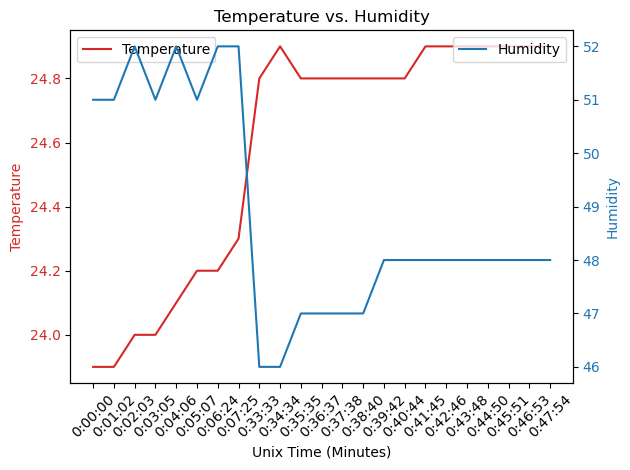

In [29]:
import matplotlib.pyplot as plt
import datetime
plot_df=pd.read_sql("SELECT * FROM sensor_values;", conn)

timestamps=[]
for i,row in plot_df.iterrows():
   print(row)
   first_time= plot_df.iloc[0]['timestamp']
   second_time= plot_df.iloc[i]['timestamp']  
   duration =  int(second_time - first_time)
   calc_seconds=str(datetime.timedelta(seconds=duration))
   print(calc_seconds)
   timestamps.append(calc_seconds)


# Create the chart
fig, ax1 = plt.subplots()
ax1.set_title('Temperature vs. Humidity')
color = 'tab:red'
ax1.set_xlabel('Unix Time (Minutes)')
ax1.set_ylabel('Temperature', color=color)
ax1.plot(timestamps,plot_df['temperature'], color=color)
ax1.tick_params(axis='y', labelcolor=color) # changes style and color of y-axis label
ax1.tick_params(axis='x', labelrotation=45)
# Create another line for the Humidity

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Humidity', color=color)  # we already handled the x-label with ax1
ax2.plot(timestamps,plot_df['humidity'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
ax1.legend(['Temperature'], loc='upper left')
ax2.legend(['Humidity'], loc='upper right')

plt.show()


In [30]:
#Write to Excel Sheet
%pip install openpyxl
#import openpype.pipeline as pypeline  # pip install openpype.pipeline to install openpype.pipeline. For windows

plot_df=pd.read_sql("SELECT * FROM sensor_values;", conn)
df=plot_df.to_excel('05b_plotting.xlsx')    

Note: you may need to restart the kernel to use updated packages.
